In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('..')
import random, math
import pyzx as zx
from fractions import Fraction
from pyzx.phasepoly import circuit_phase_polynomial_blocks, optimize_block
%config InlineBackend.figure_format = 'svg'
zx.quantomatic.quantomatic_location = r'C:\Users\John\Desktop\scala.jar'

In [3]:
def generate_parities(targets):
    parities = set()
    for i in range(4):
        a = targets[i]
        parities.add(frozenset([a]))
        for j in range(i+1,4):
            b = targets[j]
            parities.add(frozenset([a,b]))
            for k in range(j+1,4):
                c = targets[k]
                parities.add(frozenset([a,b,c]))
                for l in range(k+1,4):
                    d = targets[l]
                    parities.add(frozenset([a,b,c,d]))
    return parities

s1 = generate_parities([1,2,3,4])
s2 = generate_parities([2,3,4,5])
s3 = generate_parities([1,2,3,6])
s4 = generate_parities([1,2,3,5])
#s5 = generate_parities([1,2,3,5])
len(s1.symmetric_difference(s2).symmetric_difference(s3).symmetric_difference(s4))#.symmetric_difference(s5)

24

1/4 1/4 [1, 3, 7, 5, 1, 5, 7, 3]
1/4 3/4 [3, 3, 5, 5, 3, 5, 5, 3]
1/4 5/4 [5, 3, 3, 5, 5, 5, 3, 3]
1/4 7/4 [7, 3, 1, 5, 7, 5, 1, 3]
3/4 1/4 [1, 5, 7, 3, 1, 3, 7, 5]
3/4 3/4 [3, 5, 5, 3, 3, 3, 5, 5]
3/4 5/4 [5, 5, 3, 3, 5, 3, 3, 5]
3/4 7/4 [7, 5, 1, 3, 7, 3, 1, 5]
5/4 1/4 [1, 7, 7, 1, 1, 1, 7, 7]
5/4 3/4 [3, 7, 5, 1, 3, 1, 5, 7]
5/4 5/4 [5, 7, 3, 1, 5, 1, 3, 7]
5/4 7/4 [7, 7, 1, 1, 7, 1, 1, 7]
7/4 1/4 [1, 1, 7, 7, 1, 7, 7, 1]
7/4 3/4 [3, 1, 5, 7, 3, 7, 5, 1]
7/4 5/4 [5, 1, 3, 7, 5, 7, 3, 1]
7/4 7/4 [7, 1, 1, 7, 7, 7, 1, 1]


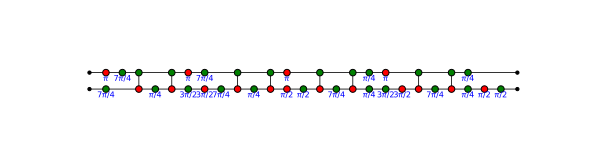

In [72]:
for i in range(1,8,2):
    alpha = Fraction(i,4)
    for j in range(1,8,2):
        beta = Fraction(j,4)

        cb = zx.Circuit(2)
        cb.add_gate("NOT",0)
        cb.add_gate("ZPhase",0,beta)
        cb.add_gate("ZPhase",1,beta)
        cb.add_gate("ParityPhase", -beta, 0, 1)
        cb.add_gate("NOT",0)

        ca = zx.Circuit(2)
        ca.add_gate("ZPhase", 1, Fraction(3,2))
        ca.add_gate("XPhase", 1, Fraction(3,2))
        ca.add_gate("ZPhase",0,alpha)
        ca.add_gate("ZPhase",1,alpha)
        ca.add_gate("ParityPhase", -alpha, 0, 1)
        ca.add_gate("XPhase", 1, Fraction(1,2))
        ca.add_gate("ZPhase", 1, Fraction(1,2))

        c = cb.copy()
        c.add_circuit(ca)
        c.add_circuit(cb.adjoint())
        c.add_circuit(ca.adjoint())

        g = c.to_graph()
        zx.simplify.full_reduce(g)
        zx.simplify.gadgetize(g)
        edges = [(49,55),(55,49),(59,65),(65,59)]
        zx.simplify.pivot_simp(g,matchf=lambda e: e in edges, quiet=True)
        print(alpha, beta, [g.phase(v).numerator for v in g.vertices() if g.phase(v) != 0 and g.phase(v).denominator!=1])

zx.draw(c)

3/4 1/4 [1, 3, 7, 5, 1, 5, 7, 3]


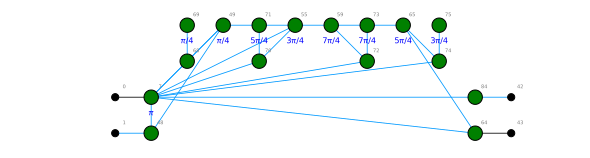

In [65]:
g = c.to_graph()
zx.simplify.full_reduce(g)
# zx.simplify.gadgetize(g)
# edges = [(49,55),(55,49),(59,65),(65,59)]
# zx.simplify.pivot_simp(g,matchf=lambda e: e in edges)
# zx.simplify.id_simp(g)
#m = zx.rules.match_gadgets_phasepoly(g)
#print(m)
print(alpha, beta, [g.phase(v).numerator for v in g.vertices() if g.phase(v) != 0 and g.phase(v).denominator!=1])
#zx.gadget_simp(g)
# zx.simplify.id_simp(g)
#zx.full_reduce(g)
g.normalise()
zx.draw(g,labels=True)

In [58]:
[3, 5, 5, 3, 3, 3, 5, 5]
[1, 5, 7, 3, 1, 3, 7, 5]
3/4 1/4 [1, 3, 7, 5, 1, 5, 7, 3]


[3, 5, 5, 3, 3, 3, 5, 5]

In [47]:
zx.compare_tensors(g.to_tensor(), zx.generate.identity(2).to_tensor())

True

In [15]:
type(g.to_tensor())

numpy.ndarray

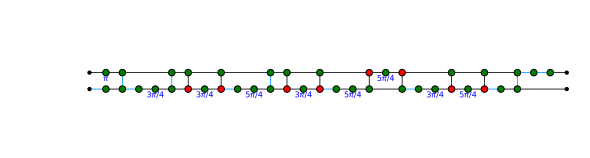

In [48]:
g2 = g.copy()
c2 = zx.extract.streaming_extract(g2)
zx.draw(c2.to_graph())

In [28]:
zx.quantomatic.edit_graph(g)

Opening Quantomatic...
Done


Graph(24 vertices, 38 edges)

In [11]:
c = zx.Circuit.from_qc_file(r'../circuits/Other/nth_prime6.tfc')
g = c.to_graph()
print(zx.tcount(g))
while True:
    zx.full_reduce(g, quiet=False)
    break
    m = zx.rules.match_gadgets_phasepoly(g)
    if not m: break
    else: 
        print("Found {:d} phasepoly matches".format(len(m)))
        print(" ".join(str((len(b)-8)*2+1) for a,b in m))
        print("T-count before: ", zx.tcount(g))
        zx.rules.apply_gadget_phasepoly(g, m)
        print("T-count after: ", zx.tcount(g))
#zx.full_reduce(g, quiet=False)
g.normalise()
zx.tcount(g)

567
spider_simp: 206. 169. 101. 57. 37. 24. 8. 3. 1.  9 iterations
id_simp: 88. 29.  2 iterations
spider_simp: 26.  1 iterations
pivot_simp: 26. 1.  2 iterations
lcomp_simp: 15. 15. 2. 2.  4 iterations
id_simp: 3.  1 iterations
spider_simp: 2. 1.  2 iterations
pivot_simp: 1.  1 iterations
lcomp_simp: 2. 2.  2 iterations
Boundary Pivot: Unfused 15 nodes for 15 possible pivots
pivot_simp: 2.  1 iterations
id_simp: 1.  1 iterations
spider_simp: 1.  1 iterations
lcomp_simp: 2. 1. 1.  3 iterations
id_simp: 1.  1 iterations
spider_simp: 1.  1 iterations
pivot_simp: 1.  1 iterations
Vertex count:  1877
T-count:  487
Gadgetized 487 nodes
pivot_simp: 169. 102. 49. 39. 29. 15. 8. 8. 5. 5. 3. 7. 7. 2. 3. 2. 2. 2. 2. 1. 3. 1. 1. 1.  24 iterations
Back to clifford_simp
id_simp: 12.  1 iterations
spider_simp: 2. 3. 1. 1. 1. 1. 1. 1. 1.  9 iterations
pivot_simp: 4. 4. 7. 9. 4. 4. 5. 6. 3. 3. 2.  11 iterations
id_simp: 28.  1 iterations
spider_simp: 13. 5. 4. 2. 1. 1. 1.  7 iterations
pivot_simp: 4. 1

279

In [7]:
g2 = g.copy()
g2.normalise()
c = zx.extract.streaming_extract(g2,quiet=True).to_basic_gates()
print(c.stats())

Circuit  on 9 qubits with 5136 gates.
        279 T-like gates
        4857 Cliffords among which 
        2371 2-qubit gates and 2280 Hadamard gates.


In [8]:
c2, blocks = circuit_phase_polynomial_blocks(c,optimize=True)
print(c2.stats())

Circuit  on 9 qubits with 3826 gates.
        279 T-like gates
        3547 Cliffords among which 
        2213 2-qubit gates and 1168 Hadamard gates.
